In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mpl_dates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
# Obtaining historical stock pricing data
ticker_symbol = 'AAPL'
ticker = yf.Ticker(ticker_symbol)

start_date = '2020-01-01'
end_date = '2023-07-01'

df = ticker.history(interval='1d', start=start_date, end=end_date)

df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2020-01-02,72.059681,73.120245,71.804274,73.059433,135480400,0.0,0.0,18263.0
2020-01-03,72.281035,73.115373,72.122925,72.349144,146322800,0.0,0.0,18264.0
2020-01-06,71.463723,72.964557,71.210743,72.925636,118387200,0.0,0.0,18267.0
2020-01-07,72.935369,73.193211,72.361308,72.582664,108872000,0.0,0.0,18268.0
2020-01-08,72.283454,74.054296,72.283454,73.750237,132079200,0.0,0.0,18269.0
...,...,...,...,...,...,...,...,...
2023-06-26,186.095106,187.310308,184.501393,184.541245,48088700,0.0,0.0,19534.0
2023-06-27,185.158789,187.648955,184.939653,187.320251,50730800,0.0,0.0,19535.0
2023-06-28,187.190770,189.153022,186.862081,188.505585,51216800,0.0,0.0,19536.0


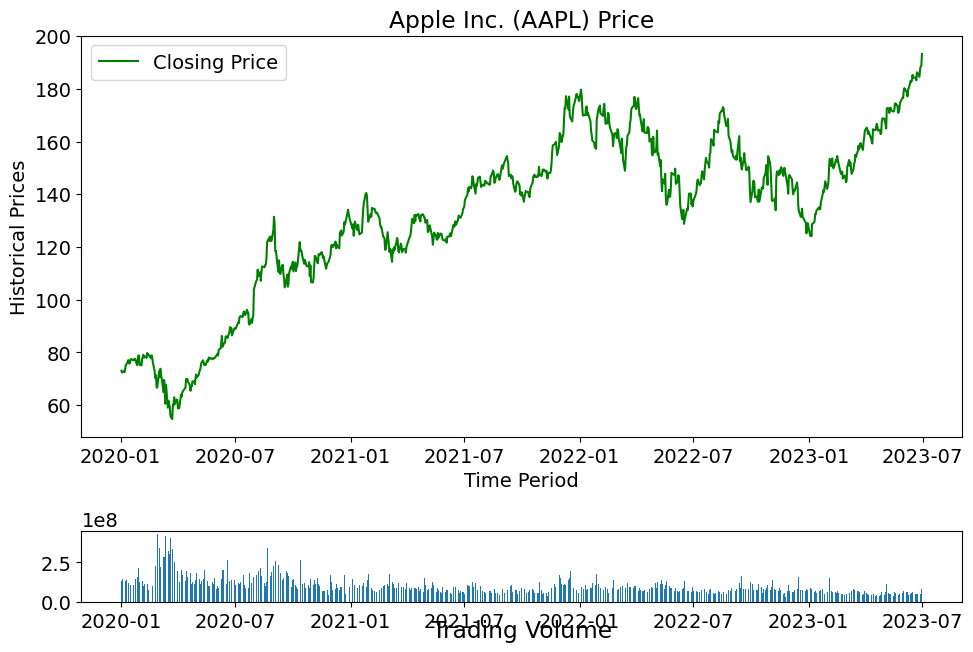

In [4]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(df['Close'].loc['2020-01-01':].index, df['Close'].loc['2020-01-01':], color = 'g', label='Closing Price')
plt.xlabel('Time Period')
plt.ylabel('Historical Prices')
plt.title('Apple Inc. (AAPL) Price')
plt.legend()
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(df['Volume'].loc['2020-01-01':].index, df['Volume'].loc['2020-01-01':])
plt.title('\nTrading Volume', y=-0.60)
plt.gcf().set_size_inches(10,8)
plt.tight_layout()

In [5]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
count,880.000000,880.000000,880.000000,880.000000,8.800000e+02,880.000000,880.000000,880.000000
mean,132.724217,134.377006,131.195661,132.865724,1.051757e+08,0.003469,0.004545,18900.031818
std,31.002304,31.215263,30.807542,31.033215,5.509420e+07,0.027347,0.134840,368.427435
min,55.611589,55.713995,51.839617,54.706997,3.519590e+07,0.000000,0.000000,18263.000000
25%,117.899020,119.385515,116.539758,118.054108,7.045718e+07,0.000000,0.000000,18578.750000
50%,140.102162,141.853798,137.686060,140.156509,8.987460e+07,0.000000,0.000000,18899.500000
75%,153.892226,156.107378,152.246641,154.491909,1.214590e+08,0.000000,0.000000,19219.250000
max,190.876224,193.715004,190.507669,193.207016,4.265100e+08,0.240000,4.000000,19538.000000


Text(0, 0.5, 'Historical Prices')

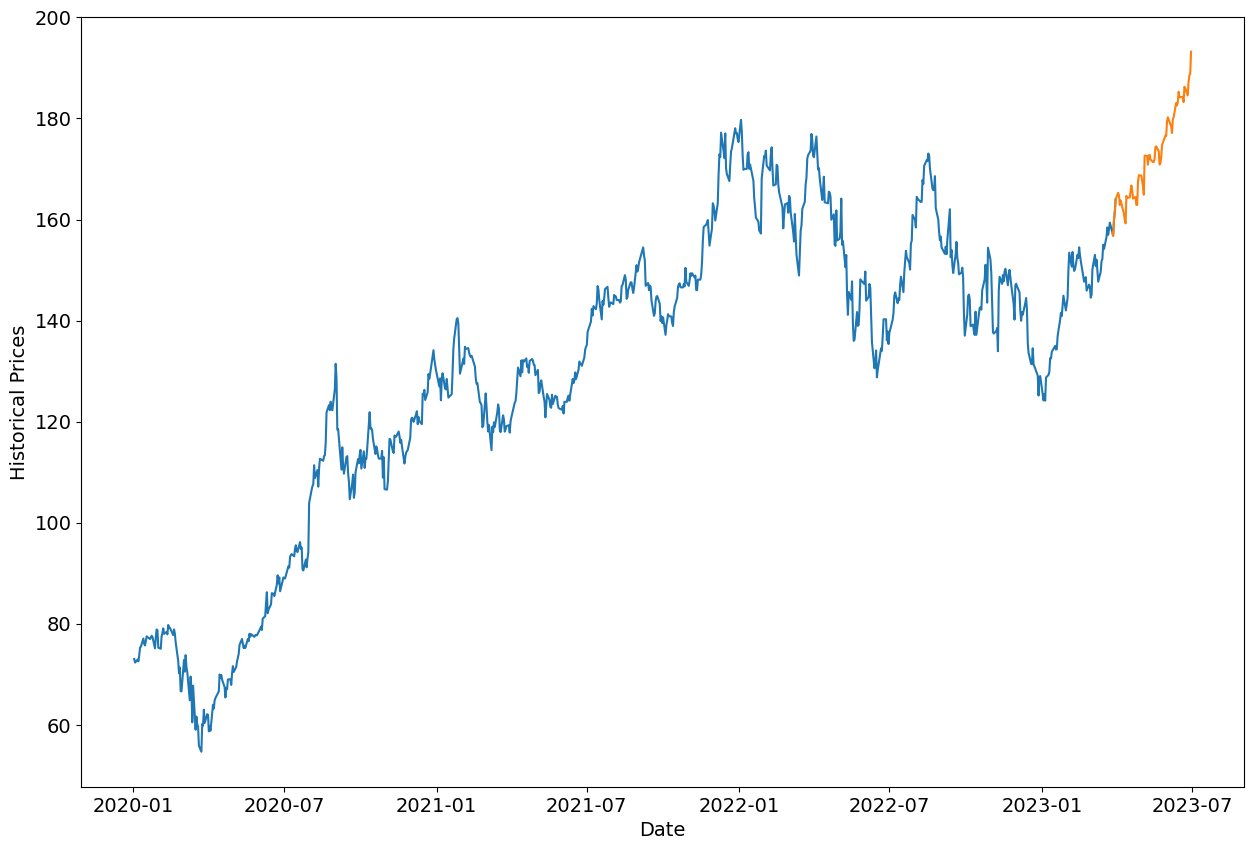

In [6]:
train = df['Close'][:818].to_numpy()
test = df['Close'][813:].to_numpy()
plt.figure(figsize=(15,10))
plt.plot(df['Close'][:818])
plt.plot(df['Close'][813:])
plt.xlabel('Date')
plt.ylabel('Historical Prices')

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train.reshape(-1,1))
test = sc.transform(test.reshape(-1,1))
train.shape

(818, 1)

In [8]:
def data_preparation(data):
    x = []
    y = []
    
    for i in range(5, len(data)):
        x.append(data[i-5:i, 0])
        y.append(data[i])
    x, y = np.array(x), np.array(y)
    
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y
x_train, y_train = data_preparation(train)
x_test, y_test = data_preparation(test)
x_train.shape

(813, 5, 1)

In [9]:
x_test.shape

(62, 5, 1)

In [10]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 5, activation = "tanh", return_sequences = True, input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 5))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])
regressor.fit(x_train, y_train, epochs = 50, batch_size = 4)

Epoch 1/50
204/204 [==============================] - 4s 6ms/step - loss: 0.2551 - accuracy: 0.0012
Epoch 2/50
204/204 [==============================] - 1s 6ms/step - loss: 0.1178 - accuracy: 0.0025
Epoch 3/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0655 - accuracy: 0.0025
Epoch 4/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0452 - accuracy: 0.0025
Epoch 5/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0317 - accuracy: 0.0025
Epoch 6/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0260 - accuracy: 0.0025
Epoch 7/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0218 - accuracy: 0.0025
Epoch 8/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0158 - accuracy: 0.0025
Epoch 9/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0139 - accuracy: 0.0012
Epoch 10/50
204/204 [==============================] - 1s 6ms/step - loss: 0.0121 - accuracy: 0.0025

In [11]:
y_pred_regressor = regressor.predict(x_train)  
y_pred_regressor  = sc.inverse_transform(y_pred_regressor) 
y_pred_regressor.shape

26/26 [==============================] - 1s 4ms/step


(813, 1)

In [12]:
y_pred_regressor_test = regressor.predict(x_test)
y_pred_regressor_test = sc.inverse_transform(y_pred_regressor_test)
y_pred_regressor_test.shape

2/2 [==============================] - 0s 6ms/step


(62, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

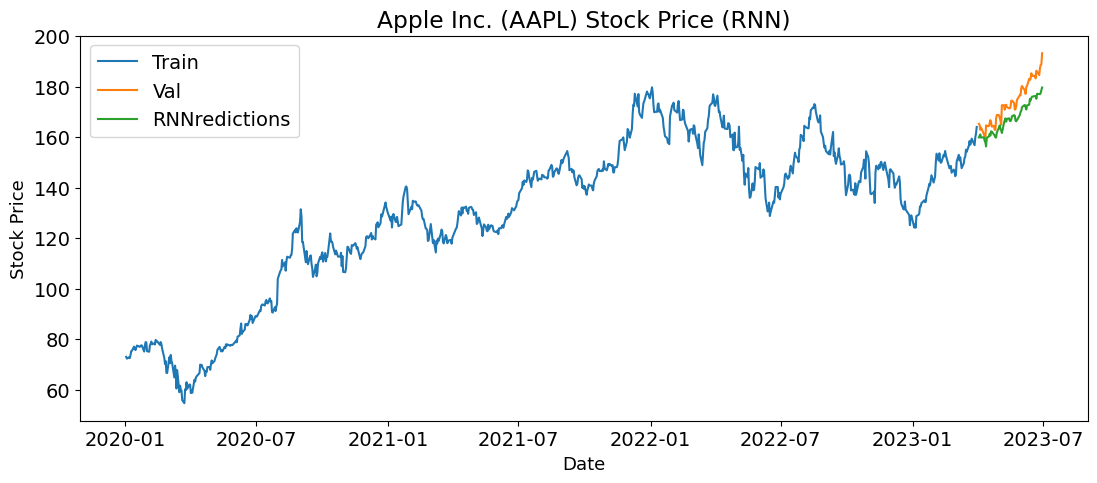

In [13]:
dtrain = df[:818]
valid = df[818:]
valid['RNNPredictions'] = y_pred_regressor_test

plt.figure(figsize=(13,5))
plt.title('Apple Inc. (AAPL) Stock Price (RNN)')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.plot(dtrain['Close'])
plt.plot(valid[['Close', 'RNNPredictions']])
plt.legend(['Train', 'Val', 'RNNredictions'], loc = 'upper left')
plt.show

In [14]:
newtest = df['Close'][818:].to_numpy()
RNNmse = np.square(np.subtract(newtest,y_pred_regressor_test)).mean()
RNNmse

148.34162570447086

In [15]:
RNNrsme = np.sqrt(RNNmse)
RNNrsme

12.179557697407196

In [16]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(units=5, return_sequences=True, input_shape=(x_train.shape[1],1)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(units=5))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(units=1))
LSTMmodel.compile(optimizer = 'adam', loss ='mean_squared_error', metrics=['accuracy'])
LSTMmodel.fit(x_train, y_train, epochs = 50, batch_size = 4)

Epoch 1/50
204/204 [==============================] - 9s 11ms/step - loss: 0.0959 - accuracy: 0.0025
Epoch 2/50
204/204 [==============================] - 2s 11ms/step - loss: 0.0377 - accuracy: 0.0025
Epoch 3/50
204/204 [==============================] - 2s 11ms/step - loss: 0.0266 - accuracy: 0.0025
Epoch 4/50
204/204 [==============================] - 2s 11ms/step - loss: 0.0208 - accuracy: 0.0025
Epoch 5/50
204/204 [==============================] - 3s 12ms/step - loss: 0.0143 - accuracy: 0.0025
Epoch 6/50
204/204 [==============================] - 2s 11ms/step - loss: 0.0146 - accuracy: 0.0025
Epoch 7/50
204/204 [==============================] - 2s 10ms/step - loss: 0.0111 - accuracy: 0.0025
Epoch 8/50
204/204 [==============================] - 2s 10ms/step - loss: 0.0112 - accuracy: 0.0025
Epoch 9/50
204/204 [==============================] - 2s 10ms/step - loss: 0.0086 - accuracy: 0.0025
Epoch 10/50
204/204 [==============================] - 2s 10ms/step - loss: 0.0086 - accura

In [17]:
y_pred_LSTMmodel = LSTMmodel.predict(x_train)  
y_pred_LSTMmodel  = sc.inverse_transform(y_pred_LSTMmodel) 
y_pred_LSTMmodel.shape

26/26 [==============================] - 2s 4ms/step


(813, 1)

In [18]:
y_pred_LSTMmodel_test = LSTMmodel.predict(x_test)
y_pred_LSTMmodel_test = sc.inverse_transform(y_pred_LSTMmodel_test)
y_pred_LSTMmodel_test.shape

2/2 [==============================] - 0s 7ms/step


(62, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

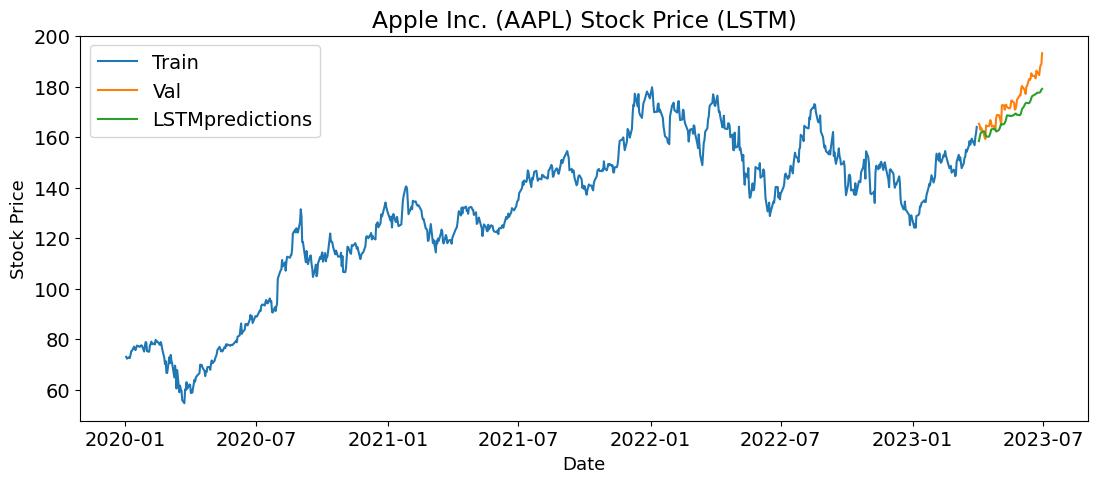

In [19]:
dtrain = df[:818]
valid = df[818:]
valid['LSTMPredictions'] = y_pred_LSTMmodel_test

plt.figure(figsize=(13,5))
plt.title('Apple Inc. (AAPL) Stock Price (LSTM)')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.plot(dtrain['Close'])
plt.plot(valid[['Close', 'LSTMPredictions']])
plt.legend(['Train', 'Val', 'LSTMpredictions'], loc = 'upper left')
plt.show

In [21]:
LSTMmse = np.square(np.subtract(newtest,y_pred_LSTMmodel_test)).mean()
LSTMrsme = np.sqrt(LSTMmse)
LSTMrsme

11.572005215147025

In [22]:
GRUmodel = Sequential()
GRUmodel.add(GRU(units=5, return_sequences=True, input_shape=(x_train.shape[1],1)))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(GRU(units=5))
GRUmodel.add(Dropout(0.2))
GRUmodel.add(Dense(units=1))
GRUmodel.compile(optimizer = 'adam', loss ='mean_squared_error', metrics=['accuracy'])
GRUmodel.fit(x_train, y_train, epochs = 50, batch_size = 4)

Epoch 1/50
204/204 [==============================] - 10s 12ms/step - loss: 0.1017 - accuracy: 0.0025
Epoch 2/50
204/204 [==============================] - 2s 11ms/step - loss: 0.0351 - accuracy: 0.0012
Epoch 3/50
204/204 [==============================] - 2s 12ms/step - loss: 0.0210 - accuracy: 0.0025
Epoch 4/50
204/204 [==============================] - 3s 16ms/step - loss: 0.0176 - accuracy: 0.0025
Epoch 5/50
204/204 [==============================] - 3s 16ms/step - loss: 0.0143 - accuracy: 0.0025
Epoch 6/50
204/204 [==============================] - 3s 14ms/step - loss: 0.0121 - accuracy: 0.0025
Epoch 7/50
204/204 [==============================] - 3s 13ms/step - loss: 0.0103 - accuracy: 0.0025
Epoch 8/50
204/204 [==============================] - 3s 12ms/step - loss: 0.0102 - accuracy: 0.0025
Epoch 9/50
204/204 [==============================] - 3s 15ms/step - loss: 0.0084 - accuracy: 0.0025
Epoch 10/50
204/204 [==============================] - 3s 16ms/step - loss: 0.0075 - accur

In [23]:
y_pred_GRUmodel = GRUmodel.predict(x_train)  
y_pred_GRUmodel  = sc.inverse_transform(y_pred_GRUmodel) 
y_pred_GRUmodel.shape

26/26 [==============================] - 1s 4ms/step


(813, 1)

In [24]:
y_pred_GRUmodel_test = GRUmodel.predict(x_test)
y_pred_GRUmodel_test = sc.inverse_transform(y_pred_GRUmodel_test)
y_pred_GRUmodel_test.shape

2/2 [==============================] - 0s 7ms/step


(62, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

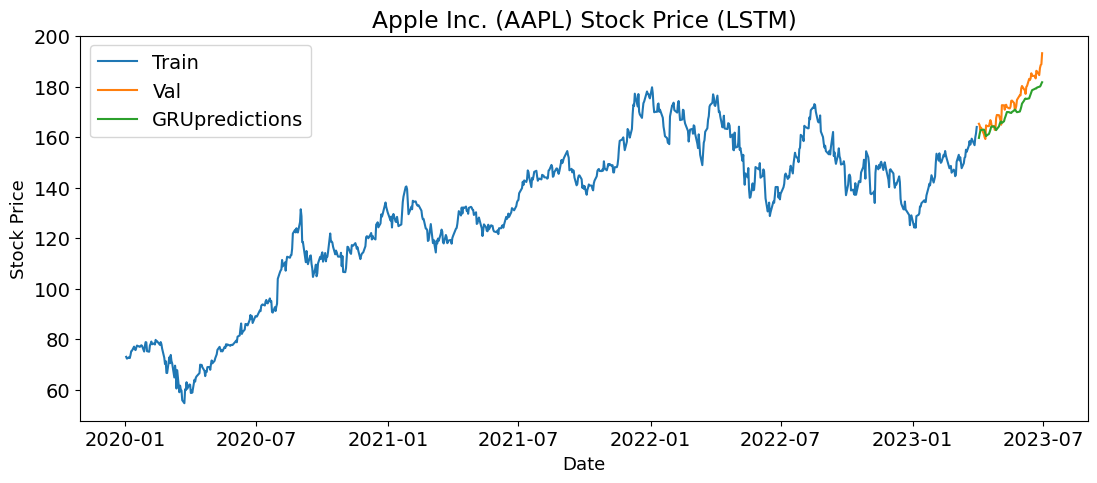

In [25]:
dtrain = df[:818]
valid = df[818:]
valid['GRUPredictions'] = y_pred_GRUmodel_test

plt.figure(figsize=(13,5))
plt.title('Apple Inc. (AAPL) Stock Price (LSTM)')
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.plot(dtrain['Close'])
plt.plot(valid[['Close', 'GRUPredictions']])
plt.legend(['Train', 'Val', 'GRUpredictions'], loc = 'upper left')
plt.show

In [26]:
GRUmse = np.square(np.subtract(newtest,y_pred_GRUmodel_test)).mean()
GRUrsme = np.sqrt(GRUmse)
GRUrsme

11.268275200303266